In [1]:
import tensorflow as tf
import cv2
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import load_model

from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from imblearn.over_sampling import RandomOverSampler

2024-05-17 16:13:27.432248: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-17 16:13:27.432610: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-17 16:13:27.435228: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-17 16:13:27.472669: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-17 16:13:28.061799: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

# Input the Dataset

In [2]:
folder_path = 'input/CK+48'

Next we will define the image size (width & height) and BATCH_SIZE

In [3]:
# Define image dimensions and batch size
IMG_HEIGHT, IMG_WIDTH = 48, 48
BATCH_SIZE = 32

Then we will combined the label, Label "Happy" and "Suprise" will be into "Happy" label, while the rest into "Unhappy" label

In [4]:
# Helper function to load and preprocess images
def load_images_from_folder(folder_path, label_map):
    images = []
    labels = []
    sub_folders = os.listdir(folder_path)
    
    for sub_folder in sub_folders:
        if sub_folder not in label_map:
            continue  # Skip sub-folder if it's not in label_map
        label = label_map[sub_folder]
        path = os.path.join(folder_path, sub_folder)
        sub_folder_images = os.listdir(path)
        
        for image_name in sub_folder_images:
            image_path = os.path.join(path, image_name)
            # print(image_path + "\t" + str(label))
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            image = cv2.resize(image, (48, 48))
            images.append(image)
            labels.append(label)
    
    images = np.array(images).reshape(-1, 48, 48, 1) / 255.0 
    labels = np.array(labels)
    
    return images, labels

# Define labels basis use case
label_map = {
    'happy': 0,       # positive emotion
    'surprise': 0,    # positive emotion
    'anger': 1,       # negative emotion
    'sadness': 1,     # negative emotion
    'contempt': 1,    # negative emotion
    'disgust': 1,     # negative emotion
    'fear': 1         # negative emotion
}

# Load images and labels from the 'input' folder
X, Y = load_images_from_folder(folder_path, label_map)

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Encode the labels
NUM_OF_CLASSES = 7
Y_train_one_hot = to_categorical(Y_train, num_classes=NUM_OF_CLASSES)
Y_test_one_hot = to_categorical(Y_test, num_classes=NUM_OF_CLASSES)


In [5]:
# Count the occurrences of each label in the training set
unique_train_labels, train_label_counts = np.unique(Y_train, return_counts=True)
print("Training set label distribution:")
for label, count in zip(unique_train_labels, train_label_counts):
    print(f"Label {label}: {count} data points")

# Count the occurrences of each label in the testing set
unique_test_labels, test_label_counts = np.unique(Y_test, return_counts=True)
print("\nTesting set label distribution:")
for label, count in zip(unique_test_labels, test_label_counts):
    print(f"Label {label}: {count} data points")

Training set label distribution:
Label 0: 365 data points
Label 1: 419 data points

Testing set label distribution:
Label 0: 91 data points
Label 1: 106 data points


From the code above, we can see that the training and testing dataset aren't exactly balanced, so the code below will fix those by using oversampling

In [6]:
# Define oversampler
oversampler = RandomOverSampler(random_state=42)

# Reshape X_train for oversampling
X_train_resampled = X_train.reshape(-1, IMG_HEIGHT * IMG_WIDTH)

# Perform oversampling
X_train_resampled, Y_train_resampled = oversampler.fit_resample(X_train_resampled, Y_train)

# Reshape X_train_resampled back to the original shape
X_train_resampled = X_train_resampled.reshape(-1, IMG_HEIGHT, IMG_WIDTH, 1)

# Check the label distribution after oversampling
unique_train_labels_resampled, train_label_counts_resampled = np.unique(Y_train_resampled, return_counts=True)
print("Training set label distribution after oversampling:")
for label, count in zip(unique_train_labels_resampled, train_label_counts_resampled):
    print(f"Label {label}: {count} data points")

Training set label distribution after oversampling:
Label 0: 419 data points
Label 1: 419 data points


In [7]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (784, 48, 48, 1)
X_test shape: (197, 48, 48, 1)


# Build the Model

In [8]:
model = Sequential([
    Conv2D(32, (3, 3),activation='relu', kernel_regularizer=l2(0.001), input_shape=(IMG_HEIGHT, IMG_WIDTH, 1)),
    Dropout(0.1),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.1),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.1),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(256, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.1),
    MaxPooling2D(pool_size=(2, 2)),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(7, activation='softmax')  # Three units for multi-class classification
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'], run_eagerly=True)

/home/faqih/Kuliah/Semester 6/AKHIR_LAB/kelompok_2/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [9]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 46, 46, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 21, 21, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 2, 2, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 421,639 (1.61 MB)

 Trainable params: 421,639 (1.61 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Then train the model
history = model.fit(
    X_train,
    Y_train_one_hot,
    batch_size=32,
    validation_data=(X_test, Y_test_one_hot),
    epochs=50
)


Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - accuracy: 0.4581 - loss: 1.4144 - val_accuracy: 0.4619 - val_loss: 0.9805
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - accuracy: 0.4583 - loss: 0.9086 - val_accuracy: 0.5381 - val_loss: 0.8432
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - accuracy: 0.5157 - loss: 0.8349 - val_accuracy: 0.5381 - val_loss: 0.8187
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - accuracy: 0.5053 - loss: 0.8040 - val_accuracy: 0.4619 - val_loss: 0.7863
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - accuracy: 0.4915 - loss: 0.7760 - val_accuracy: 0.7005 - val_loss: 0.7446
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - accuracy: 0.6431 - loss: 0.7233 - val_accuracy: 0.7360 - val_loss: 0.6017
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - accuracy: 0.7725 - loss: 0.5383 - val_accuracy: 0.7919 - val_loss: 0.5227
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - accuracy: 0.8353 - loss: 0.4378 - val_accuracy: 0.

In [11]:
# Specify the file path where you want to save the model
model_save_path = 'model.h5'

# Save the model
model.save(model_save_path)

print("Model saved successfully.")

Model saved successfully.


# Model Evaluation

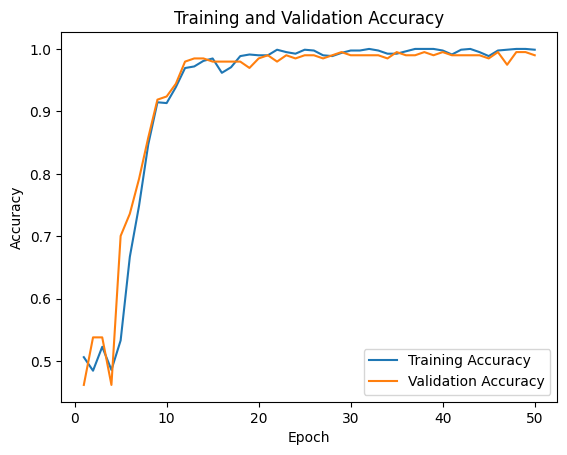

In [13]:
import matplotlib.pyplot as plt
import os

# Load the saved model
model = load_model('model.h5')

# Retrieve a list of list results on training and test data sets for each training epoch
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

save_filename = 'train_val_accuracy_plot.png'  # Change to your desired filename

# Save the plot to the specified directory and filename
plt.savefig(save_filename)

# Display the plot
plt.show()
